In [9]:
'''
This notebook is used to conduct data analysis. I run regressions, compute classification reports,
compute conditional expectations/standard deviations, compute correlations, and produce scatterplots.

Most of the code in this first cell is from portfolios_and_cumulative_returns.py and trains the models.


Reference:
For help with learning how to manipulate pandas dataframes and how to use matplotlib/scikit-learn/statsmodels, I have asked GPT for examples.
I have also linked documentation that I found to be helpful for learning how to use libraries/APIs throughout the code.
'''

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# see docs: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
# need to concatenate all data into one dataframe
all_files = [
    'reg_data_with_close/articles_2023_month_01.csv',
    'reg_data_with_close/articles_2023_month_02.csv',
    'reg_data_with_close/articles_2023_month_03.csv',
    'reg_data_with_close/articles_2023_month_04.csv',
    'reg_data_with_close/articles_2023_month_05.csv',
    'reg_data_with_close/articles_2023_month_06.csv',
    'reg_data_with_close/articles_2023_month_07.csv',
    'reg_data_with_close/articles_2023_month_08.csv',
    'reg_data_with_close/articles_2023_month_09.csv',
    'reg_data_with_close/articles_2023_month_10.csv',
    'reg_data_with_close/articles_2023_month_11.csv',
    'reg_data_with_close/articles_2023_month_12.csv',
]
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

# usual datetime conversion since news article publishing times are in mixed formats
df['timestamp'] = pd.to_datetime(df['publishedAt'], utc=True, format='mixed')
df['date'] = df['timestamp'].dt.date

# convert all timestamps to EST so we can drop those outside of market hours
df['timestamp_est'] = df['timestamp'].dt.tz_convert('EST')

# compute hour as float for each article
df['hour_est'] = df['timestamp_est'].dt.hour + (df['timestamp_est'].dt.minute / 60)

# take subset of articles that were published within market hours for their respective RIC's market
df = df[(df['RIC'].str.endswith(".N") & ((df['hour_est'] >= 9.5) & (df['hour_est'] <= 16))) | 
        (df['RIC'].str.endswith(".T") & ((df['hour_est'] >= 19) | (df['hour_est'] <= 2))) | 
        (df['RIC'].str.endswith(".OQ") & ((df['hour_est'] >= 9.5) & (df['hour_est'] <= 16))) | 
        (df['RIC'].str.endswith(".L") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5))) |
        (df['RIC'].str.endswith(".NS") & ((df['hour_est'] >= 22.75) | (df['hour_est'] <= 5))) |
        (df['RIC'].str.endswith(".PA") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5))) | 
        (df['RIC'].str.endswith(".HK") & ((df['hour_est'] >= 21.5) | (df['hour_est'] <= 4))) |
        (df['RIC'].str.endswith(".SS") & ((df['hour_est'] >= 21.5) | (df['hour_est'] <= 3))) |
        (df['RIC'].str.endswith(".SZ") & ((df['hour_est'] >= 21.5) | (df['hour_est'] <= 3))) |
        (df['RIC'].str.endswith(".F") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5))) |
        (df['RIC'].str.endswith(".AS") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5))) |
        (df['RIC'].str.endswith(".MI") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5))) |
        (df['RIC'].str.endswith(".BR") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5))) |
        (df['RIC'].str.endswith(".TO") & ((df['hour_est'] >= 9.5) & (df['hour_est'] <= 16))) |
        (df['RIC'].str.endswith(".AX") & ((df['hour_est'] >= 18) | (df['hour_est'] <= 0))) |
        (df['RIC'].str.endswith(".BO") & ((df['hour_est'] >= 22.75) | (df['hour_est'] <= 5))) |
        (df['RIC'].str.endswith(".KS") & ((df['hour_est'] >= 19) | (df['hour_est'] <= 1.5))) |
        (df['RIC'].str.endswith(".TW") & ((df['hour_est'] >= 20.5) | (df['hour_est'] <= 1))) |
        (df['RIC'].str.endswith(".SI") & ((df['hour_est'] >= 20.5) | (df['hour_est'] <= 4))) |
        (df['RIC'].str.endswith(".ST") & ((df['hour_est'] >= 3) & (df['hour_est'] <= 11.5)))]

# drop rows that are missing values for these close prices
df = df.dropna(subset=['t-2', 't', 't+1', 'SPY_t-2', 'SPY_t', 'SPY_t+1'])
df['train_returns'] = (df['t+1'] - df['t-2']) / df['t-2']
df['test_returns'] = (df['t+1'] - df['t']) / df['t']
df['sr_sign'] = np.where(df['train_returns'] > 0, 1, -1)
df['test_sign'] = np.where(df['test_returns'] > 0, 1, -1)
df['SPY_train_returns'] = (df['SPY_t+1'] - df['SPY_t-2']) / df['SPY_t-2']
df['SPY_test_returns'] = (df['SPY_t+1'] - df['SPY_t']) / df['SPY_t']

print("Counts after filtering for articles published within market hours:")
# see docs: https://stackoverflow.com/questions/33271098/get-a-frequency-count-based-on-multiple-dataframe-columns
print(df.groupby(by=["category", "source"]).size())

# convert sentiment label to number for later GPT-L logistic regression
sentiment_dict = {'positive': 1, 'neutral': 0, 'negative': -1}
df['gpt_d_label'] = df['sentiment'].map(sentiment_dict)

# split half train/half test by dates
dates = df['date'].unique()
split_index = int(len(dates) * 0.5)
train_dates, test_dates = dates[:split_index], dates[split_index:]

# see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html
# filter by train/test dates
train_df, test_df = df[df['date'].isin(train_dates)], df[df['date'].isin(test_dates)]

# to test on just a news-category subset
# test_df = test_df[test_df['category'] == 'Earnings Expectations or Earnings Reports']

embedding_cols = ['embedding_' + str(i) for i in range(1536)]
X_train = train_df[embedding_cols].values
X_test = test_df[embedding_cols].values
y_train = train_df['sr_sign'].values

# see docs: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=50, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


# Stock-Return-Based Logistic Regression Strategy

# see docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#
# class_weight param used to adjust weights to increase value placed on infrequent labels
sr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
sr_model.fit(X_train, y_train)

# see docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
# obtain positive-label probabilities for each article
test_df['sr_prob'] = sr_model.predict_proba(X_test)[:, 1]
test_df['sr_label'] = sr_model.predict(X_test)


y_train = train_df['gpt_d_label'].values
gpt_l_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
gpt_l_model.fit(X_train, y_train)

predicted_probabilities = gpt_l_model.predict_proba(X_test)
test_df['gpt_l_label'] = gpt_l_model.predict(X_test)

print(gpt_l_model.classes_) # order of classes is -1, 0, 1
test_df['gpt_l_negative_prob'] = predicted_probabilities[:, 0]  # logistic negative-label probability
test_df['gpt_l_positive_prob'] = predicted_probabilities[:, 2]  # logistic positive-label probability
test_df['gpt_l_positive_prob_rescaled'] = test_df['gpt_l_positive_prob'] / (test_df['gpt_l_positive_prob'] + test_df['gpt_l_negative_prob'])


/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/176627242.py:34: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)


Counts after filtering for articles published within market hours:
category                                   source                                  
Earnings Expectations or Earnings Reports  {'name': 'Bloomberg', 'id': 'bloomberg'}     923
                                           {'name': 'Reuters', 'id': 'reuters'}        3158
Fines Incurred                             {'name': 'Bloomberg', 'id': 'bloomberg'}     513
                                           {'name': 'Reuters', 'id': 'reuters'}         777
Legal and Regulatory                       {'name': 'Bloomberg', 'id': 'bloomberg'}     553
                                           {'name': 'Reuters', 'id': 'reuters'}        1317
Merger or Acquisition                      {'name': 'Bloomberg', 'id': 'bloomberg'}    1576
                                           {'name': 'Reuters', 'id': 'reuters'}        2293
New Technology and Innovation              {'name': 'Bloomberg', 'id': 'bloomberg'}     528
                     

/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/176627242.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sr_prob'] = sr_model.predict_proba(X_test)[:, 1]
/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/176627242.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sr_label'] = sr_model.predict(X_test)


[-1  0  1]


/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/176627242.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['gpt_l_label'] = gpt_l_model.predict(X_test)
/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/176627242.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['gpt_l_negative_prob'] = predicted_probabilities[:, 0]  # logistic negative-label probability
/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/176627242.py:130: SettingWithCopyW

In [5]:
raw_article_df = pd.read_csv('articles_2023.csv')
print("Raw Article Count:")
print(raw_article_df['source'].value_counts())

Raw Article Count:
source
{'name': 'Reuters', 'id': 'reuters'}        99310
{'name': 'Bloomberg', 'id': 'bloomberg'}    56243
Name: count, dtype: int64


/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/4272839573.py:1: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_article_df = pd.read_csv('articles_2023.csv')


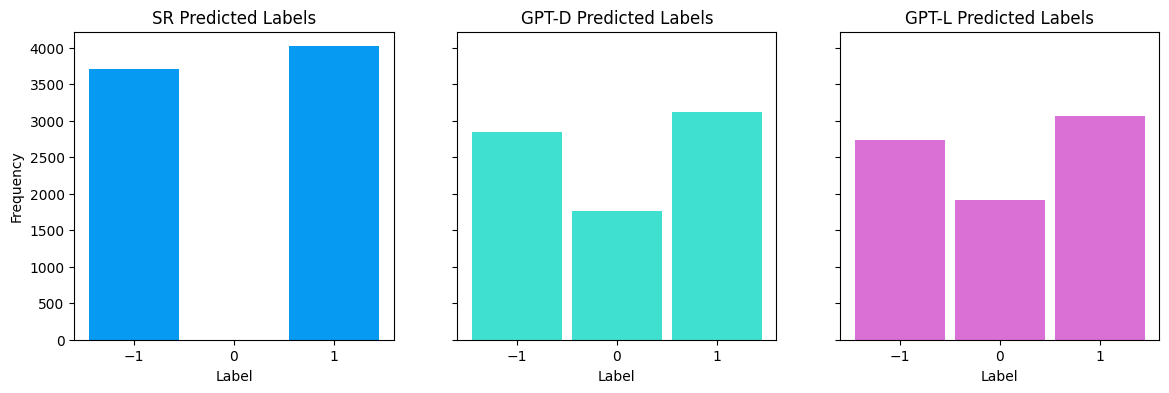

In [155]:
# label histograms
# helpful: https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
# helpful: https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# helpful: https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created
# helpful: https://www.geeksforgeeks.org/add-space-between-histogram-bars-in-matplotlib/
# helpful: https://stackoverflow.com/questions/42172440/how-to-set-color-in-matplotlib-histograms
# helpful: https://matplotlib.org/stable/users/explain/colors/colors.html

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
ax1.hist(test_df['sr_label'], bins=[-1.5, -0.5, 0.5, 1.5], rwidth=0.9, color="#069AF3")
ax1.set_title("SR Predicted Labels")
ax1.set_xlabel("Label")
ax1.set_xticks([-1, 0, 1])
ax1.set_ylabel("Frequency")
ax2.hist(test_df['gpt_d_label'], bins=[-1.5, -0.5, 0.5, 1.5], rwidth=0.9, color="turquoise")
ax2.set_title("GPT-D Predicted Labels")
ax2.set_xlabel("Label")
ax2.set_xticks([-1, 0, 1])
ax3.hist(test_df['gpt_l_label'], bins=[-1.5, -0.5, 0.5, 1.5], rwidth=0.9, color="orchid")
ax3.set_title("GPT-L Predicted Labels")
ax3.set_xlabel("Label")
ax3.set_xticks([-1, 0, 1])
fig.savefig("label_hist.png")

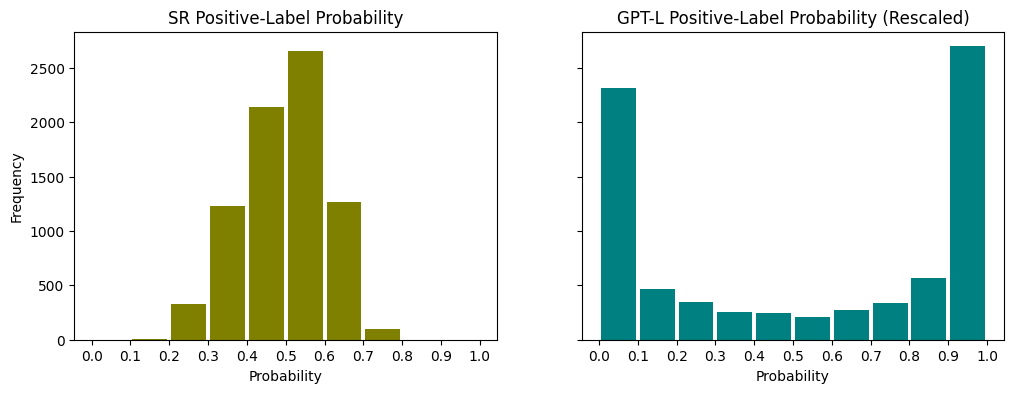

In [172]:
# probability histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.hist(test_df['sr_prob'], bins=np.linspace(0, 1, 11), rwidth=0.9, color="olive")
ax1.set_title("SR Positive-Label Probability")
ax1.set_xlabel("Probability")
ax1.set_xticks(np.linspace(0, 1, 11))
ax1.set_ylabel("Frequency")
ax2.hist(test_df['gpt_l_positive_prob_rescaled'], bins=np.linspace(0, 1, 11), rwidth=0.9, color="teal")
ax2.set_title("GPT-L Positive-Label Probability (Rescaled)")
ax2.set_xlabel("Probability")
ax2.set_xticks(np.linspace(0, 1, 11))
fig.savefig("prob_hist.png")

/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/3491040616.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'lightblue' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df['gpt_d_label'] == -1, ['color']] = 'lightblue',


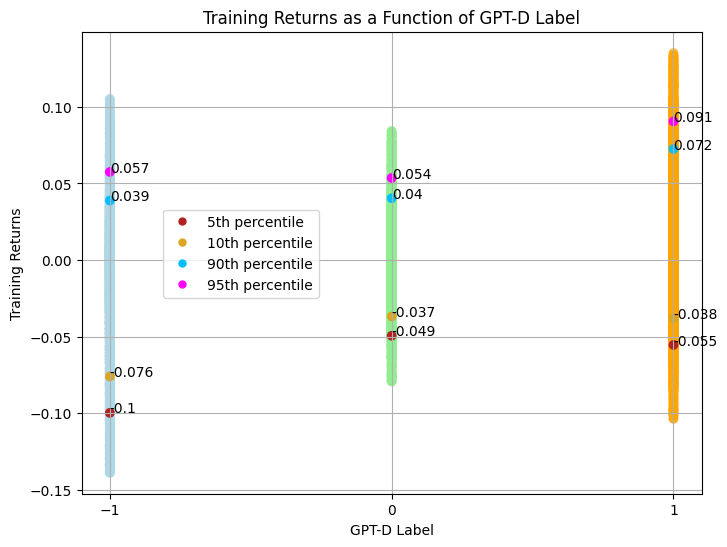

In [259]:
# remove outliers
# simple method: outlier if greater than q3 + 1.5 * iqr or less than q1 - 1.5 * iqr
scatter_df = df[['gpt_d_label', 'train_returns']]
new_df = pd.DataFrame()
percentile_x = []
percentile_y = []
percentile_color = []
for label, group in scatter_df.groupby('gpt_d_label'):
    median = group['train_returns'].median()
    q3 = group['train_returns'].quantile(0.75)
    q1 = group['train_returns'].quantile(0.25)
    iqr = q3 - q1
    group = group[(group['train_returns'] < q3 + 1.5*iqr) & (group['train_returns'] > q1 - 1.5*iqr)]
    new_df = pd.concat([new_df, group])    
    percentile_5 = group['train_returns'].quantile(0.05)
    percentile_10 = group['train_returns'].quantile(0.10)
    percentile_90 = group['train_returns'].quantile(0.90)
    percentile_95 = group['train_returns'].quantile(0.95)
    percentile_x.extend([label, label, label, label])
    percentile_y.extend([percentile_5, percentile_10, percentile_90, percentile_95])
    # https://matplotlib.org/stable/gallery/color/named_colors.html
    percentile_color.extend(['firebrick', 'goldenrod', 'deepskyblue', 'magenta'])

# see: https://stackoverflow.com/questions/19226488/change-one-value-based-on-another-value-in-pandas
new_df.loc[new_df['gpt_d_label'] == -1, ['color']] = 'lightblue',
new_df.loc[new_df['gpt_d_label'] == 0, ['color']] = 'lightgreen',
new_df.loc[new_df['gpt_d_label'] == 1, ['color']] = 'orange',

# see: https://www.freecodecamp.org/news/matplotlib-figure-size-change-plot-size-in-python/
plt.figure(figsize=(8,6))
plt.scatter(new_df['gpt_d_label'], new_df['train_returns'], color=new_df['color'], alpha=0.5)
plt.scatter(percentile_x, percentile_y, color=percentile_color)
for i in range(12):
    if percentile_y[i] > 0:
        plt.annotate(str(round(percentile_y[i], 3))[:5], (percentile_x[i], percentile_y[i]))
    else:
        plt.annotate(str(round(percentile_y[i], 3))[:6], (percentile_x[i], percentile_y[i]))
plt.title("Training Returns as a Function of GPT-D Label")
plt.xlabel("GPT-D Label")
plt.xticks([-1, 0, 1])
plt.ylabel("Training Returns")
plt.grid()


# see: https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend
from matplotlib.lines import Line2D
handles, labels = plt.gca().get_legend_handles_labels()
handles = []
percentile_5_label = Line2D([0], [0], label='5th percentile', marker='.', markersize=10, markerfacecolor='firebrick', markeredgecolor='firebrick', linestyle='')
percentile_10_label = Line2D([0], [0], label='10th percentile', marker='.', markersize=10, markerfacecolor='goldenrod', markeredgecolor='goldenrod', linestyle='')
percentile_90_label = Line2D([0], [0], label='90th percentile', marker='.', markersize=10, markerfacecolor='deepskyblue', markeredgecolor='deepskyblue', linestyle='')
percentile_95_label = Line2D([0], [0], label='95th percentile', marker='.', markersize=10, markerfacecolor='magenta', markeredgecolor='magenta', linestyle='')

handles.extend([percentile_5_label, percentile_10_label, percentile_90_label, percentile_95_label])

plt.legend(handles=handles, bbox_to_anchor=(0.12, 0.63))
plt.savefig('training_returns_scatter.png')
# plt.show()

/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/1279988595.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'lightblue' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df['gpt_d_label'] == -1, ['color']] = 'lightblue',


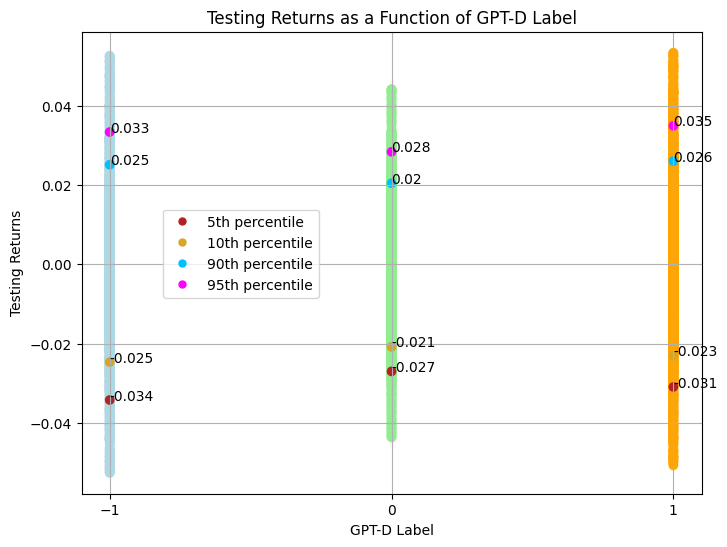

In [258]:
# remove outliers
# simple method: outlier if greater than q3 + 1.5 * iqr or less than q1 - 1.5 * iqr
scatter_df = df[['gpt_d_label', 'test_returns']]
new_df = pd.DataFrame()
percentile_x = []
percentile_y = []
percentile_color = []
for label, group in scatter_df.groupby('gpt_d_label'):
    median = group['test_returns'].median()
    q3 = group['test_returns'].quantile(0.75)
    q1 = group['test_returns'].quantile(0.25)
    iqr = q3 - q1
    group = group[(group['test_returns'] < q3 + 1.5*iqr) & (group['test_returns'] > q1 - 1.5*iqr)]
    new_df = pd.concat([new_df, group])    
    percentile_5 = group['test_returns'].quantile(0.05)
    percentile_10 = group['test_returns'].quantile(0.10)
    percentile_90 = group['test_returns'].quantile(0.90)
    percentile_95 = group['test_returns'].quantile(0.95)
    percentile_x.extend([label, label, label, label])
    percentile_y.extend([percentile_5, percentile_10, percentile_90, percentile_95])
    # https://matplotlib.org/stable/gallery/color/named_colors.html
    percentile_color.extend(['firebrick', 'goldenrod', 'deepskyblue', 'magenta'])

# see: https://stackoverflow.com/questions/19226488/change-one-value-based-on-another-value-in-pandas
new_df.loc[new_df['gpt_d_label'] == -1, ['color']] = 'lightblue',
new_df.loc[new_df['gpt_d_label'] == 0, ['color']] = 'lightgreen',
new_df.loc[new_df['gpt_d_label'] == 1, ['color']] = 'orange',

# see: https://www.freecodecamp.org/news/matplotlib-figure-size-change-plot-size-in-python/
plt.figure(figsize=(8,6))
plt.scatter(new_df['gpt_d_label'], new_df['test_returns'], color=new_df['color'], alpha=0.5)
plt.scatter(percentile_x, percentile_y, color=percentile_color)
for i in range(12):
    if percentile_y[i] > 0:
        plt.annotate(str(round(percentile_y[i], 3))[:5], (percentile_x[i], percentile_y[i]))
    else:
        plt.annotate(str(round(percentile_y[i], 3))[:6], (percentile_x[i], percentile_y[i]))
plt.title("Testing Returns as a Function of GPT-D Label")
plt.xlabel("GPT-D Label")
plt.xticks([-1, 0, 1])
plt.ylabel("Testing Returns")
plt.grid()


# see: https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend
from matplotlib.lines import Line2D
handles, labels = plt.gca().get_legend_handles_labels()
handles = []
percentile_5_label = Line2D([0], [0], label='5th percentile', marker='.', markersize=10, markerfacecolor='firebrick', markeredgecolor='firebrick', linestyle='')
percentile_10_label = Line2D([0], [0], label='10th percentile', marker='.', markersize=10, markerfacecolor='goldenrod', markeredgecolor='goldenrod', linestyle='')
percentile_90_label = Line2D([0], [0], label='90th percentile', marker='.', markersize=10, markerfacecolor='deepskyblue', markeredgecolor='deepskyblue', linestyle='')
percentile_95_label = Line2D([0], [0], label='95th percentile', marker='.', markersize=10, markerfacecolor='magenta', markeredgecolor='magenta', linestyle='')

handles.extend([percentile_5_label, percentile_10_label, percentile_90_label, percentile_95_label])

plt.legend(handles=handles, bbox_to_anchor=(0.12, 0.63))
plt.savefig('testing_returns_scatter.png')
# plt.show()

In [28]:
# see docs: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print("SR_label")
print(classification_report(test_df['test_sign'], test_df['sr_label']))
print(confusion_matrix(test_df['test_sign'], test_df['sr_label']))
print("GPT_D_Label")
print(classification_report(test_df['test_sign'], test_df['gpt_d_label']))
print(confusion_matrix(test_df['test_sign'], test_df['gpt_d_label']))
print("GPT_L_Label")
print(classification_report(test_df['test_sign'], test_df['gpt_l_label']))
print(confusion_matrix(test_df['test_sign'], test_df['gpt_l_label']))

# positive/negative subset of GPT_D and GPT_L prediction accuracy: (since we don't have true 0 labels)
gpt_d_accuracy_df = test_df[(test_df['gpt_d_label'] == 1) | (test_df['gpt_d_label'] == -1)]
print("rescaled gpt_d")
print(classification_report(gpt_d_accuracy_df['test_sign'], gpt_d_accuracy_df['gpt_d_label']))
print(confusion_matrix(gpt_d_accuracy_df['test_sign'], gpt_d_accuracy_df['gpt_d_label']))

gpt_l_accuracy_df = test_df[(test_df['gpt_l_label'] == 1) | (test_df['gpt_l_label'] == -1)]
print("rescaled gpt_l")
print(classification_report(gpt_l_accuracy_df['test_sign'], gpt_l_accuracy_df['gpt_l_label']))
print(confusion_matrix(gpt_l_accuracy_df['test_sign'], gpt_l_accuracy_df['gpt_l_label']))

joint_pred_accuracy_df = test_df[((test_df['sr_label'] == 1) & (test_df['gpt_d_label'] == 1)) |
                                 ((test_df['sr_label'] == -1) & (test_df['gpt_d_label'] == -1))]
print("joint prediction accuracy (sr and gpt_d labels agree)")
print(classification_report(joint_pred_accuracy_df['test_sign'], joint_pred_accuracy_df['sr_label']))
print(confusion_matrix(joint_pred_accuracy_df['test_sign'], joint_pred_accuracy_df['sr_label']))

high_impact_earnings_df = test_df[(test_df['category'] == 'Earnings Expectations or Earnings Reports') & 
                                  ((test_df['test_returns'] >= 0.05) | (test_df['test_returns'] <= -0.05))]
print("SR_label earnings:")
print(classification_report(high_impact_earnings_df['test_sign'], high_impact_earnings_df['sr_label']))
print(confusion_matrix(high_impact_earnings_df['test_sign'], high_impact_earnings_df['sr_label']))

high_impact_earnings_gpt_d_df = gpt_d_accuracy_df[(test_df['category'] == 'Earnings Expectations or Earnings Reports') & 
                                                  ((test_df['test_returns'] >= 0.05) | (test_df['test_returns'] <= -0.05))]
print("gpt_d_label earnings:")
print(classification_report(high_impact_earnings_gpt_d_df['test_sign'], high_impact_earnings_gpt_d_df['gpt_d_label']))
print(confusion_matrix(high_impact_earnings_gpt_d_df['test_sign'], high_impact_earnings_gpt_d_df['gpt_d_label']))

high_impact_earnings_gpt_l_df = gpt_l_accuracy_df[(test_df['category'] == 'Earnings Expectations or Earnings Reports') & 
                                                  ((test_df['test_returns'] >= 0.05) | (test_df['test_returns'] <= -0.05))]
print("gpt_l_label earnings")
print(classification_report(high_impact_earnings_gpt_l_df['test_sign'], high_impact_earnings_gpt_l_df['gpt_l_label']))
print(confusion_matrix(high_impact_earnings_gpt_l_df['test_sign'], high_impact_earnings_gpt_l_df['gpt_l_label']))

SR_label
              precision    recall  f1-score   support

          -1       0.55      0.51      0.53      3964
           1       0.52      0.55      0.53      3752

    accuracy                           0.53      7716
   macro avg       0.53      0.53      0.53      7716
weighted avg       0.53      0.53      0.53      7716

[[2020 1944]
 [1680 2072]]
GPT_D_Label
              precision    recall  f1-score   support

          -1       0.54      0.38      0.45      3964
           0       0.00      0.00      0.00         0
           1       0.51      0.42      0.46      3752

    accuracy                           0.40      7716
   macro avg       0.35      0.27      0.30      7716
weighted avg       0.52      0.40      0.45      7716

[[1526  905 1533]
 [   0    0    0]
 [1321  853 1578]]
GPT_L_Label
              precision    recall  f1-score   support

          -1       0.54      0.37      0.44      3964
           0       0.00      0.00      0.00         0
           1  

/Users/alex/Desktop/Princeton/Princeton Year 4/Senior Thesis/final_code/thesis/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Desktop/Princeton/Princeton Year 4/Senior Thesis/final_code/thesis/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Desktop/Princeton/Princeton Year 4/Senior Thesis/final_code/thesis/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no tru

              precision    recall  f1-score   support

          -1       0.56      0.51      0.53      2508
           1       0.51      0.56      0.53      2271

    accuracy                           0.53      4779
   macro avg       0.54      0.54      0.53      4779
weighted avg       0.54      0.53      0.53      4779

[[1277 1231]
 [ 997 1274]]
SR_label earnings:
              precision    recall  f1-score   support

          -1       0.66      0.73      0.70       116
           1       0.72      0.65      0.68       122

    accuracy                           0.69       238
   macro avg       0.69      0.69      0.69       238
weighted avg       0.69      0.69      0.69       238

[[85 31]
 [43 79]]
gpt_d_label earnings:
              precision    recall  f1-score   support

          -1       0.69      0.65      0.67       110
           1       0.68      0.72      0.70       113

    accuracy                           0.69       223
   macro avg       0.69      0.69      0.

/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/412254851.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_impact_earnings_gpt_l_df = gpt_l_accuracy_df[(test_df['category'] == 'Earnings Expectations or Earnings Reports') &


In [11]:
# summary statistics
print('sr_label mean', test_df['sr_label'].mean())
print('sr_label stdev', test_df['sr_label'].std())
print('gpt_d_label mean', test_df['gpt_d_label'].mean())
print('gpt_d_label stdev', test_df['gpt_d_label'].std())
print('gpt_l_label mean', test_df['gpt_l_label'].mean())
print('gpt_l_label stdev', test_df['gpt_l_label'].std())
print('sr_prob mean', test_df['sr_prob'].mean())
print('sr_prob stdev', test_df['sr_prob'].std())
print('gpt_l_positive_prob_rescaled mean', test_df['gpt_l_positive_prob_rescaled'].mean())
print('gpt_l_positive_prob_rescaled stdev', test_df['gpt_l_positive_prob_rescaled'].std())


sr_label mean 0.04095386210471747
sr_label stdev 0.9992257910050061
gpt_d_label mean 0.03421461897356143
gpt_d_label stdev 0.8781178939763437
gpt_l_label mean 0.04186106791083463
gpt_l_label stdev 0.8658180024456729
sr_prob mean 0.49595925478524017
sr_prob stdev 0.10727144146561612
gpt_l_positive_prob_rescaled mean 0.5280350037477232
gpt_l_positive_prob_rescaled stdev 0.4080496948649316


In [37]:
# correlations
print("SR_label, SR_prob", test_df['sr_label'].corr(test_df['sr_prob']))
print("SR_label, GPT_D_label", test_df['sr_label'].corr(test_df['gpt_d_label']))
print("SR_label, GPT_L_label", test_df['sr_label'].corr(test_df['gpt_l_label']))
print("SR_label, GPT_L_prob", test_df['sr_label'].corr(test_df['gpt_l_positive_prob']))
print("SR_prob, GPT_D_label", test_df['sr_prob'].corr(test_df['gpt_d_label']))
print("SR_prob, GPT_L_label", test_df['sr_prob'].corr(test_df['gpt_l_label']))
print("SR_prob, GPT_L_prob", test_df['sr_prob'].corr(test_df['gpt_l_positive_prob']))
print("GPT_D_label, GPT_L_label", test_df['gpt_d_label'].corr(test_df['gpt_l_label']))
print("GPT_D_label, GPT_L_prob", test_df['gpt_d_label'].corr(test_df['gpt_l_positive_prob']))
print("GPT_L_label, GPT_L_prob", test_df['gpt_l_label'].corr(test_df['gpt_l_positive_prob']))


SR_label, SR_prob 0.8221780425809536
SR_label, GPT_D_label 0.5302050211552956
SR_label, GPT_L_label 0.5635938964764515
SR_label, GPT_L_prob 0.5794469501955133
SR_prob, GPT_D_label 0.5993589438622632
SR_prob, GPT_L_label 0.6467388425695246
SR_prob, GPT_L_prob 0.6530862230354624
GPT_D_label, GPT_L_label 0.7891635114463462
GPT_D_label, GPT_L_prob 0.7860915470960664
GPT_L_label, GPT_L_prob 0.8933655457750299


In [53]:
# conditional means and standard deviations

# see docs: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.mean.html
# condition on GPT_D labels
print(test_df.groupby(['gpt_d_label'])['sr_label'].mean())
print(test_df.groupby(['gpt_d_label'])['sr_label'].std())

print(test_df.groupby(['gpt_d_label'])['sr_prob'].mean())
print(test_df.groupby(['gpt_d_label'])['sr_prob'].std())

# condition on sr_prob quantile
test_df['sr_prob_bins'] = pd.cut(test_df['sr_prob'], 5)
print(test_df.groupby(['sr_prob_bins'])['gpt_d_label'].mean())
print(test_df.groupby(['sr_prob_bins'])['gpt_d_label'].std())
print(test_df.groupby(['sr_prob_bins'])['gpt_l_label'].mean())
print(test_df.groupby(['sr_prob_bins'])['gpt_l_label'].std())
print(test_df.groupby(['sr_prob_bins'])['gpt_l_positive_prob'].mean())
print(test_df.groupby(['sr_prob_bins'])['gpt_l_positive_prob'].std())

gpt_d_label
-1   -0.597471
 0    0.067122
 1    0.610415
Name: sr_label, dtype: float64
gpt_d_label
-1    0.802031
 0    0.998029
 1    0.792209
Name: sr_label, dtype: float64
gpt_d_label
-1    0.416014
 0    0.507128
 1    0.562809
Name: sr_prob, dtype: float64
gpt_d_label
-1    0.096750
 0    0.081020
 1    0.076681
Name: sr_prob, dtype: float64
sr_prob_bins
(0.176, 0.297]   -0.971246
(0.297, 0.418]   -0.700517
(0.418, 0.538]   -0.017403
(0.538, 0.658]    0.544931
(0.658, 0.779]    0.742105
Name: gpt_d_label, dtype: float64
sr_prob_bins
(0.176, 0.297]    0.202082
(0.297, 0.418]    0.603302
(0.418, 0.538]    0.830128
(0.538, 0.658]    0.692350
(0.658, 0.779]    0.559698
Name: gpt_d_label, dtype: float64
sr_prob_bins
(0.176, 0.297]   -0.984026
(0.297, 0.418]   -0.739327
(0.418, 0.538]   -0.020884
(0.538, 0.658]    0.577189
(0.658, 0.779]    0.871053
Name: gpt_l_label, dtype: float64
sr_prob_bins
(0.176, 0.297]    0.169086
(0.297, 0.418]    0.547988
(0.418, 0.538]    0.804052
(0.538, 0.

/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/129534981.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sr_prob_bins'] = pd.cut(test_df['sr_prob'], 5)
/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/129534981.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(test_df.groupby(['sr_prob_bins'])['gpt_d_label'].mean())
/var/folders/pv/8p1pvchj201bllw6r0x2t0p40000gn/T/ipykernel_72374/129534981.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

In [55]:
# condition on category
print("sr_label")
print(test_df.groupby(['category'])['sr_label'].mean())
print(test_df.groupby(['category'])['sr_label'].std())
print("sr_prob")
print(test_df.groupby(['category'])['sr_prob'].mean())
print(test_df.groupby(['category'])['sr_prob'].std())
print("gpt_d_label")
print(test_df.groupby(['category'])['gpt_d_label'].mean())
print(test_df.groupby(['category'])['gpt_d_label'].std())

sr_label
category
Earnings Expectations or Earnings Reports   -0.045655
Fines Incurred                              -0.613115
Legal and Regulatory                        -0.027382
Merger or Acquisition                        0.303907
New Technology and Innovation                0.546584
Personnel/Management Changes                -0.226891
Product Launch                               0.191375
Supply or Demand Effect                     -0.074184
Name: sr_label, dtype: float64
category
Earnings Expectations or Earnings Reports    0.999203
Fines Incurred                               0.790642
Legal and Regulatory                         1.000173
Merger or Acquisition                        0.952944
New Technology and Innovation                0.838055
Personnel/Management Changes                 0.974505
Product Launch                               0.982843
Supply or Demand Effect                      0.998727
Name: sr_label, dtype: float64
sr_prob
category
Earnings Expectations or Earni

In [59]:
# correlations by category
for category, group in test_df.groupby(['category']):
    print(category)
    # print(group)
    print("SR_label, GPT_D_label", group['sr_label'].corr(group['gpt_d_label']))
    print("SR_prob, GPT_D_label", group['sr_prob'].corr(group['gpt_d_label']))

('Earnings Expectations or Earnings Reports',)
SR_label, GPT_D_label 0.672975375587461
SR_prob, GPT_D_label 0.7466772084321028
('Fines Incurred',)
SR_label, GPT_D_label 0.35638135186573844
SR_prob, GPT_D_label 0.39871034500858543
('Legal and Regulatory',)
SR_label, GPT_D_label 0.24996630257672184
SR_prob, GPT_D_label 0.29345590830326246
('Merger or Acquisition',)
SR_label, GPT_D_label 0.40629018079545326
SR_prob, GPT_D_label 0.4665482154054574
('New Technology and Innovation',)
SR_label, GPT_D_label 0.467745528590271
SR_prob, GPT_D_label 0.5057426371069629
('Personnel/Management Changes',)
SR_label, GPT_D_label 0.4801143462009452
SR_prob, GPT_D_label 0.5460883297392432
('Product Launch',)
SR_label, GPT_D_label 0.46491378233220965
SR_prob, GPT_D_label 0.5732187195833949
('Supply or Demand Effect',)
SR_label, GPT_D_label 0.501029520337149
SR_prob, GPT_D_label 0.6006282063148789


In [80]:
# regressions, see docs: https://www.statsmodels.org/stable/regression.html
# will use HC1 robust standard errors, see docs: https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/linear_model.py

# helpful guide: https://www.datarobot.com/blog/multiple-regression-using-statsmodels/

# get indicators in pandas, see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
# see: https://stackoverflow.com/questions/37265312/how-to-create-dummies-for-certain-columns-with-pandas-get-dummies
# and: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

# convert boolean indicator to integer in {0, 1}
# see: https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe

import statsmodels.api as sm
X = pd.get_dummies(test_df, prefix='gpt_d', columns=['gpt_d_label'])[['gpt_d_1', 'gpt_d_-1']].astype(int)
X = sm.add_constant(X)
y = test_df['sr_label']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = pd.get_dummies(test_df, prefix='gpt_d', columns=['gpt_d_label'])[['gpt_d_1', 'gpt_d_-1']].astype(int)
X = sm.add_constant(X)
y = test_df['sr_prob']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               sr_label   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     1706.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:58:38   Log-Likelihood:                -9665.2
No. Observations:                7716   AIC:                         1.934e+04
Df Residuals:                    7713   BIC:                         1.936e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0671      0.024      2.820      0.0

In [106]:
X = pd.get_dummies(test_df, prefix='gpt_l', columns=['gpt_l_label'])[['gpt_l_1', 'gpt_l_-1']].astype(int)
X = pd.concat([X, test_df['SPY_train_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['train_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = pd.get_dummies(test_df, prefix='gpt_l', columns=['gpt_l_label'])[['gpt_l_1', 'gpt_l_-1']].astype(int)
X = pd.concat([X, test_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          train_returns   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     212.0
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          3.73e-132
Time:                        17:14:09   Log-Likelihood:                 7354.1
No. Observations:                7716   AIC:                        -1.470e+04
Df Residuals:                    7712   BIC:                        -1.467e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0034      0.00

In [103]:
X = test_df['gpt_l_positive_prob']
X = pd.concat([X, test_df['SPY_train_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['train_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = test_df['gpt_l_positive_prob']
X = pd.concat([X, test_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          train_returns   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     269.5
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          7.11e-114
Time:                        17:12:03   Log-Likelihood:                 7339.3
No. Observations:                7716   AIC:                        -1.467e+04
Df Residuals:                    7713   BIC:                        -1.465e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0252    

In [108]:
X = pd.get_dummies(test_df, prefix='gpt_d', columns=['gpt_d_label'])[['gpt_d_1', 'gpt_d_-1']].astype(int)
X = pd.concat([X, test_df['SPY_train_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['train_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = pd.get_dummies(test_df, prefix='gpt_d', columns=['gpt_d_label'])[['gpt_d_1', 'gpt_d_-1']].astype(int)
X = pd.concat([X, test_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          train_returns   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     250.7
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          2.88e-155
Time:                        17:17:32   Log-Likelihood:                 7413.5
No. Observations:                7716   AIC:                        -1.482e+04
Df Residuals:                    7712   BIC:                        -1.479e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0027      0.00

In [110]:
X = pd.get_dummies(test_df, prefix='sr', columns=['sr_label'])[['sr_1']].astype(int)
X = pd.concat([X, test_df['SPY_train_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['train_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = pd.get_dummies(test_df, prefix='sr', columns=['sr_label'])[['sr_1']].astype(int)
X = pd.concat([X, test_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          train_returns   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     225.7
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           5.43e-96
Time:                        17:18:51   Log-Likelihood:                 7262.4
No. Observations:                7716   AIC:                        -1.452e+04
Df Residuals:                    7713   BIC:                        -1.450e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0193      0.00

In [111]:
X = test_df['sr_prob']
X = pd.concat([X, test_df['SPY_train_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['train_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = test_df['sr_prob']
X = pd.concat([X, test_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = test_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          train_returns   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     333.7
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          9.81e-140
Time:                        17:19:30   Log-Likelihood:                 7389.2
No. Observations:                7716   AIC:                        -1.477e+04
Df Residuals:                    7713   BIC:                        -1.475e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1104      0.00

In [107]:
earnings_df = test_df[test_df['category'] == 'Earnings Expectations or Earnings Reports']

X = pd.get_dummies(earnings_df, prefix='gpt_d', columns=['gpt_d_label'])[['gpt_d_1', 'gpt_d_-1']].astype(int)
X = pd.concat([X, earnings_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = earnings_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = pd.get_dummies(earnings_df, prefix='gpt_l', columns=['gpt_l_label'])[['gpt_l_1', 'gpt_l_-1']].astype(int)
X = pd.concat([X, earnings_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = earnings_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

X = pd.get_dummies(earnings_df, prefix='sr', columns=['sr_label'])[['sr_1']].astype(int)
X = pd.concat([X, earnings_df['SPY_test_returns']], axis=1)
X = sm.add_constant(X)
y = earnings_df['test_returns']
lm = sm.OLS(y, X).fit(cov_type='HC1')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           test_returns   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     30.99
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           1.38e-19
Time:                        17:15:35   Log-Likelihood:                 3421.2
No. Observations:                2037   AIC:                            -6834.
Df Residuals:                    2033   BIC:                            -6812.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0011      0.002  